In [ ]:
from google.colab import drive
drive.mount('/gdrive')

%cd /gdrive/My\ Drive/Colab\ Notebooks/esun_tbrain/thesis_reading

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).
/gdrive/My Drive/Colab Notebooks/esun_tbrain/thesis_reading


In [ ]:
!pip install transformers
!pip install sentencepiece
!pip install nlpaug
!pip install fairseq>=0.9.0 sacremoses>=0.0.43 fastBPE>=0.1.0
!apt-get install cmake build-essential pkg-config libgoogle-perftools-dev

Reading package lists... Done
Building dependency tree       
Reading state information... Done
build-essential is already the newest version (12.4ubuntu1).
libgoogle-perftools-dev is already the newest version (2.5-2.2ubuntu3).
pkg-config is already the newest version (0.29.1-0ubuntu2).
cmake is already the newest version (3.10.2-1ubuntu2.18.04.1).
0 upgraded, 0 newly installed, 0 to remove and 15 not upgraded.


from https://towardsdatascience.com/transformers-for-multilabel-classification-71a1a0daf5e1

In [ ]:
import pickle
from ast import literal_eval
import gc
import re

import pandas as pd
import numpy as np

from tqdm import trange
from tqdm.auto import tqdm

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics import classification_report, confusion_matrix, multilabel_confusion_matrix, f1_score, accuracy_score

import tensorflow as tf
import torch
from torch.nn import BCEWithLogitsLoss, BCELoss
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from torch.optim.lr_scheduler import ReduceLROnPlateau

from keras.preprocessing.sequence import pad_sequences
from transformers import *

import nlpaug.augmenter.word as naw

import matplotlib.pyplot as plt

In [ ]:
seed = 0
torch.manual_seed(seed)
np.random.seed(seed)

max_length = 400 # 512

threshold = 0.4  # 0.5

train_ratio = 0.75
validation_ratio = 0.15
test_ratio = 0.10

# Select a batch size for training. For fine-tuning with XLNet, the authors recommend a batch size of 32, 48, or 128. We will use 32 here to avoid memory issues.
batch_size = 16  # 16

# Number of training epochs (authors recommend between 2 and 4)
epochs = 6

path_model = 'scibert_uncased_backtranlation_3label_2.model'

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n_gpu = torch.cuda.device_count()
torch.cuda.get_device_name(0)

'Tesla P100-PCIE-16GB'

In [ ]:
df_train = pd.read_csv('data/trainset.csv')
# df_train['text'] = df_train.Title + ' <TEP> ' + df_train.Abstract
df_train['text'] = df_train.Title + ' [SEP] ' + df_train.Abstract.replace('\$\$\$', '[SEP]', regex=True)

df_train

,Title,Abstract,Classifications,text
0,"Distinctiveness, complexity, and repeatability...",This paper proposes three measures to quantify...,ENGINEERING,"Distinctiveness, complexity, and repeatability..."
1,An Adaptable Fast Matrix Multiplication Algori...,In this paper we present an adaptable fast mat...,EMPIRICAL,An Adaptable Fast Matrix Multiplication Algori...
2,Trimming the Multipath for Efficient Dynamic R...,Multipath routing is a trivial way to exploit ...,THEORETICAL ENGINEERING,Trimming the Multipath for Efficient Dynamic R...
3,Learning Word Embeddings from Speech,"In this paper, we propose a novel deep neural ...",ENGINEERING EMPIRICAL,Learning Word Embeddings from Speech [SEP] In ...
4,A Unified Model for Near and Remote Sensing,We propose a novel convolutional neural networ...,THEORETICAL ENGINEERING,A Unified Model for Near and Remote Sensing [S...
...,...,...,...,...
6995,Small vulnerable sets determine large network ...,The understanding of cascading failures in com...,THEORETICAL EMPIRICAL,Small vulnerable sets determine large network ...
6996,Emergence of Human-comparable Balancing Behavi...,This paper presents a hierarchical framework b...,ENGINEERING,Emergence of Human-comparable Balancing Behavi...
6997,Neural Paraphrase Generation with Stacked Resi...,"In this paper, we propose a novel neural appro...",EMPIRICAL,Neural Paraphrase Generation with Stacked Resi...
6998,Efficient Twitter Sentiment Classification usi...,As microblogging services like Twitter are bec...,EMPIRICAL,Efficient Twitter Sentiment Classification usi...


In [ ]:
df_train['Abstract'][0]

'This paper proposes three measures to quantify the characteristics of online signature templates in terms of distinctiveness, complexity and repeatability.$$$A distinctiveness measure of a signature template is computed from a set of enrolled signature samples and a statistical assumption about random signatures.$$$Secondly, a complexity measure of the template is derived from a set of enrolled signature samples.$$$Finally, given a signature template, a measure to quantify the repeatability of the online signature is derived from a validation set of samples.$$$These three measures can then be used as an indicator for the performance of the system in rejecting random forgery samples and skilled forgery samples and the performance of users in providing accepted genuine samples, respectively.$$$The effectiveness of these three measures and their applications are demonstrated through experiments performed on three online signature datasets and one keystroke dynamics dataset using differen

train data text len distribution


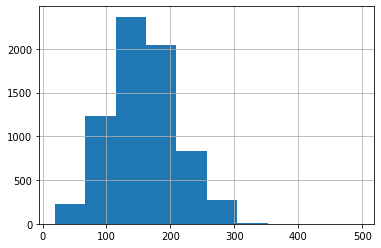

In [ ]:
print('train data text len distribution')
df_train.text.str.split(' ').map(len).hist()

In [ ]:
# backtranslated cant be used for validation and test
df_train_bt = pd.read_csv('data/train_backtrans.csv')
df_train_bt['text_backtrans'] = df_train_bt['text_backtrans'].str[2:-2]

In [ ]:
df_test = pd.read_csv('data/testset.csv')
# df_test['text'] = df_test.Title + ' <TEP> ' + df_test.Abstract
df_test['text'] = df_test.Title + ' [SEP] ' + df_test.Abstract.replace('\$\$\$', '[SEP]', regex=True)

df_test

,Id,Title,Abstract,text
0,1,Efficient Visual Coding: From Retina To V2,The human visual system has a hierarchical str...,Efficient Visual Coding: From Retina To V2 [SE...
1,2,PolyMorph: Increasing P300 Spelling Efficiency...,P300 is an electric signal emitted by brain ab...,PolyMorph: Increasing P300 Spelling Efficiency...
2,3,"Cooperative Cognitive Networks: Optimal, Distr...",This paper considers the cooperation between a...,"Cooperative Cognitive Networks: Optimal, Distr..."
3,4,Indoor occupancy estimation from carbon dioxid...,This paper presents an indoor occupancy estima...,Indoor occupancy estimation from carbon dioxid...
4,5,Lower Bound for General Circuits Computing Cli...,We prove an exponential lower bound for genera...,Lower Bound for General Circuits Computing Cli...
...,...,...,...,...
39995,39996,"Structure and Recognition of 3,4-leaf Powers o...",A graph is a $k$-leaf power of a tree $T$ if i...,"Structure and Recognition of 3,4-leaf Powers o..."
39996,39997,Extended Report: The Implicit Calculus,Generic programming (GP) is an increasingly im...,Extended Report: The Implicit Calculus [SEP] G...
39997,39998,ConGUSTo: (HT)Condor Graphical Unified Supervi...,HTCondor is a distributed job scheduler develo...,ConGUSTo: (HT)Condor Graphical Unified Supervi...
39998,39999,Protein Folding in the Hexagonal Prism Lattice...,Predicting protein secondary structure using l...,Protein Folding in the Hexagonal Prism Lattice...


In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
vec = CountVectorizer()
train_label = vec.fit_transform(df_train.Classifications).toarray()
df_train['one_hot_labels'] = train_label.tolist()
num_labels = len(vec.get_feature_names())
print('All classes:', vec.get_feature_names())

All classes: ['empirical', 'engineering', 'others', 'theoretical']


In [ ]:
# labels = list(df_train.one_hot_labels.values)  # 4 label
# list_classes = vec.get_feature_names()
# num_labels = len(list_classes)

labels = [[l[0], l[1], l[3]] for l in df_train.one_hot_labels.values]  # 3 label
list_classes = [v for i, v in enumerate(vec.get_feature_names()) if i != 2]
num_labels = len(list_classes)
print('All classes modified:', list_classes)

All classes modified: ['empirical', 'engineering', 'theoretical']


In [ ]:
tokenizer = AutoTokenizer.from_pretrained('allenai/scibert_scivocab_uncased')
encodings = tokenizer(list(df_train.text.values), max_length=max_length, padding=True, truncation=True) # tokenizer's encoding method
encodings_bt = tokenizer(list(df_train_bt.text_backtrans.values), max_length=max_length, padding=True, truncation=True) # tokenizer's encoding method

# encodings = tokenizer.batch_encode_plus(list(df_train.text.values), max_length=max_length, pad_to_max_length=True) # tokenizer's encoding method
# encodings_bt = tokenizer.batch_encode_plus(list(df_train_bt.text_backtrans.values), max_length=max_length, pad_to_max_length=True) # tokenizer's encoding method

In [ ]:
input_ids = encodings['input_ids'] # tokenized and encoded sentences
token_type_ids = encodings['token_type_ids'] # token type ids
attention_masks = encodings['attention_mask'] # attention masks

input_ids_bt = encodings_bt['input_ids'] # tokenized and encoded sentences
token_type_ids_bt = encodings_bt['token_type_ids'] # token type ids
attention_masks_bt = encodings_bt['attention_mask'] # attention masks

In [ ]:
tokenizer.convert_ids_to_tokens(input_ids[0])

['[CLS]',
 'distinctive',
 '##ness',
 ',',
 'complexity',
 ',',
 'and',
 'repeatability',
 'of',
 'online',
 'signature',
 'templates',
 '[SEP]',
 'this',
 'paper',
 'proposes',
 'three',
 'measures',
 'to',
 'quantify',
 'the',
 'characteristics',
 'of',
 'online',
 'signature',
 'templates',
 'in',
 'terms',
 'of',
 'distinctive',
 '##ness',
 ',',
 'complexity',
 'and',
 'repeatability',
 '.',
 '[SEP]',
 'a',
 'distinctive',
 '##ness',
 'measure',
 'of',
 'a',
 'signature',
 'template',
 'is',
 'computed',
 'from',
 'a',
 'set',
 'of',
 'enrolled',
 'signature',
 'samples',
 'and',
 'a',
 'statistical',
 'assumption',
 'about',
 'random',
 'signatures',
 '.',
 '[SEP]',
 'secondly',
 ',',
 'a',
 'complexity',
 'measure',
 'of',
 'the',
 'template',
 'is',
 'derived',
 'from',
 'a',
 'set',
 'of',
 'enrolled',
 'signature',
 'samples',
 '.',
 '[SEP]',
 'finally',
 ',',
 'given',
 'a',
 'signature',
 'template',
 ',',
 'a',
 'measure',
 'to',
 'quantify',
 'the',
 'repeatability',
 'of'

In [ ]:
# Identifying indices of 'one_hot_labels' entries that only occur once - this will allow us to stratify split our training data later
label_counts = df_train.one_hot_labels.astype(str).value_counts()
print('label freq sorted')
print(label_counts, '\n')
one_freq = label_counts[label_counts==1].keys()
one_freq_idxs = sorted(list(df_train[df_train.one_hot_labels.astype(str).isin(one_freq)].index), reverse=True)
print('df label indices with only one instance: ', one_freq_idxs)

label freq sorted
[0, 0, 0, 1]    1964
[0, 1, 0, 0]    1902
[1, 0, 0, 0]    1009
[0, 1, 0, 1]     736
[1, 1, 0, 0]     613
[1, 0, 0, 1]     375
[0, 0, 1, 0]     259
[1, 1, 0, 1]     142
Name: one_hot_labels, dtype: int64 

df label indices with only one instance:  []


In [ ]:
# Use train_test_split to split our data into train, validation, test sets
train_inputs, validation_inputs, train_labels, validation_labels, train_token_types, validation_token_types, train_masks, validation_masks, train_index, val_index = train_test_split(
    input_ids, labels, token_type_ids, attention_masks, np.array(df_train.index), stratify=labels, test_size=1-train_ratio)

validation_inputs, test_inputs, validation_labels, test_labels, validation_token_types, test_token_types, validation_masks, test_masks = train_test_split(
    validation_inputs, validation_labels, validation_token_types, validation_masks, stratify=validation_labels, test_size=test_ratio/(test_ratio + validation_ratio))

# Add backtranslated data to train_data
# train_inputs.extend(input_ids_bt)
# train_labels.extend(labels)
# train_masks.extend(attention_masks_bt)
# train_token_types.extend(token_type_ids_bt)

# Convert all of our data into torch tensors, the required datatype for our model, Add backtranslated data to train_data
train_inputs = torch.cat((torch.tensor(train_inputs), torch.tensor(input_ids_bt)[train_index, :]), dim=0)
train_labels = torch.cat((torch.tensor(train_labels), torch.tensor(labels)[train_index, :]), dim=0)
train_masks = torch.cat((torch.tensor(train_masks), torch.tensor(attention_masks_bt)[train_index, :]), dim=0)
train_token_types = torch.cat((torch.tensor(train_token_types), torch.tensor(token_type_ids_bt)[train_index, :]), dim=0)

validation_inputs = torch.tensor(validation_inputs)
validation_labels = torch.tensor(validation_labels)
validation_masks = torch.tensor(validation_masks)
validation_token_types = torch.tensor(validation_token_types)

test_inputs = torch.tensor(test_inputs)
test_labels = torch.tensor(test_labels)
test_masks = torch.tensor(test_masks)
test_token_types = torch.tensor(test_token_types)

In [ ]:
# Create an iterator of our data with torch DataLoader. This helps save on memory during training because, unlike a for loop, 
# with an iterator the entire dataset does not need to be loaded into memory

train_data = TensorDataset(train_inputs, train_masks, train_labels, train_token_types)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels, validation_token_types)
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size)

test_data = TensorDataset(test_inputs, test_masks, test_labels, test_token_types)
test_sampler = SequentialSampler(test_data)
test_dataloader = DataLoader(test_data, sampler=test_sampler, batch_size=batch_size)

In [ ]:
# Load model, the pretrained model will include a single linear classification layer on top for classification. 
try: 
    model
    del model
except:
    pass

# Clear GPU mem
torch.cuda.empty_cache()

model = AutoModelForSequenceClassification.from_pretrained('allenai/scibert_scivocab_uncased', num_labels=num_labels)
model.cuda()

Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.decoder.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification we

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(31090, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

In [ ]:
# setting custom optimization parameters. You may implement a scheduler here as well.
optimizer = AdamW(model.parameters(), lr=2e-6)

In [ ]:
# Store our loss and accuracy for plotting
list_train_loss = []
list_val_loss = []
list_train_f1_micro = []
list_val_f1_micro = []

best_f1_micro = 0
best_val_loss = np.inf

# scheduler = ReduceLROnPlateau(optimizer, 'min', patience=patience)

# trange is a tqdm wrapper around the normal python range
for i_epoch in tqdm(range(epochs), desc="Epoch"):
  # Training
  
  # Set our model to training mode (as opposed to evaluation mode)
  model.train()

  # Tracking variables
  tr_loss = 0 #running loss
  nb_tr_examples, nb_tr_steps = 0, 0
  logit_preds,true_labels,pred_labels,tokenized_texts = [],[],[],[]

  # Train the data for one epoch
  for step, batch in tqdm(enumerate(train_dataloader), total=len(train_dataloader)):
    # Add batch to GPU
    batch = tuple(t.to(device) for t in batch)
    # Unpack the inputs from our dataloader
    b_input_ids, b_input_mask, b_labels, b_token_types = batch
    # Clear out the gradients (by default they accumulate)
    optimizer.zero_grad()

    # Forward pass for multilabel classification
    outputs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)
    logits = outputs[0]
    loss_func = BCEWithLogitsLoss() 
    loss = loss_func(logits.view(-1,num_labels),b_labels.type_as(logits).view(-1, num_labels))  #convert labels to float for calculation
    pred_label = torch.sigmoid(logits)

    with torch.no_grad():
        b_logit_pred = logits.detach().cpu().numpy()
        pred_label = pred_label.to('cpu').numpy()
        b_labels = b_labels.to('cpu').numpy()  

    tokenized_texts.append(b_input_ids)
    logit_preds.append(b_logit_pred)
    true_labels.append(b_labels)
    pred_labels.append(pred_label)

    # Backward pass
    loss.backward()
    # Update parameters and take a step using the computed gradient
    optimizer.step()
    # Update tracking variables
    tr_loss += loss.item()
    nb_tr_examples += b_input_ids.size(0)
    nb_tr_steps += 1

  list_train_loss += [tr_loss/nb_tr_examples]
  print("Train loss: {}".format(tr_loss/nb_tr_examples))

  # Flatten outputs
  pred_labels = [item for sublist in pred_labels for item in sublist]
  true_labels = [item for sublist in true_labels for item in sublist]

  # Calculate Accuracy
  pred_bools = [pl>threshold for pl in pred_labels]
  true_bools = [tl==1 for tl in true_labels]
  tr_f1_accuracy = f1_score(true_bools,pred_bools,average='micro')*100
  tr_flat_accuracy = accuracy_score(true_bools, pred_bools)*100

  list_train_f1_micro.append(tr_f1_accuracy)

  ###############################################################################

  # Validation

  # Put model in evaluation mode to evaluate loss on the validation set
  model.eval()

  # Variables to gather full output
  val_loss = 0 #running loss
  nb_val_examples, nb_val_steps = 0, 0
  logit_preds,true_labels,pred_labels,tokenized_texts = [],[],[],[]

  # Predict
  for i, batch in tqdm(enumerate(validation_dataloader), total=len(validation_dataloader)):
    batch = tuple(t.to(device) for t in batch)
    # Unpack the inputs from our dataloader
    b_input_ids, b_input_mask, b_labels, b_token_types = batch
    with torch.no_grad():
      # Forward pass
      outs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)
      b_logit_pred = outs[0]
      loss_func = BCEWithLogitsLoss() 
      loss = loss_func(b_logit_pred.view(-1,num_labels),b_labels.type_as(logits).view(-1, num_labels)) #convert labels to float for calculation
      pred_label = torch.sigmoid(b_logit_pred)

      b_logit_pred = b_logit_pred.detach().cpu().numpy()
      pred_label = pred_label.to('cpu').numpy()
      b_labels = b_labels.to('cpu').numpy()

    tokenized_texts.append(b_input_ids)
    logit_preds.append(b_logit_pred)
    true_labels.append(b_labels)
    pred_labels.append(pred_label)

    # Update tracking variables
    val_loss += loss.item()
    nb_val_examples += b_input_ids.size(0)
    nb_val_steps += 1

  print("val loss: {}".format(val_loss/nb_val_examples))
  list_val_loss += [val_loss/nb_val_examples]

  # Flatten outputs
  pred_labels = [item for sublist in pred_labels for item in sublist]
  true_labels = [item for sublist in true_labels for item in sublist]

  # Calculate Accuracy
  pred_bools = [pl>threshold for pl in pred_labels]
  true_bools = [tl==1 for tl in true_labels]
  val_f1_accuracy = f1_score(true_bools,pred_bools,average='micro')*100
  val_flat_accuracy = accuracy_score(true_bools, pred_bools)*100

  list_val_f1_micro.append(val_f1_accuracy)

  print('F1 Validation Accuracy: ', val_f1_accuracy)
  print('Flat Validation Accuracy: ', val_flat_accuracy)

  if val_f1_accuracy > best_f1_micro and best_val_loss > val_loss/nb_val_examples:
    print(f'Best model saved at epoch {i_epoch}')
    best_val_loss = val_loss/nb_val_examples
    best_f1_micro = val_f1_accuracy
    model.save_pretrained(path_model)


Train loss: 0.035171104865414755



val loss: 0.030785737662088305
F1 Validation Accuracy:  73.05263157894738
Flat Validation Accuracy:  45.04761904761905
Best model saved at epoch 0



Train loss: 0.03090072367588679



val loss: 0.029615390840030852
F1 Validation Accuracy:  73.23232323232324
Flat Validation Accuracy:  47.714285714285715
Best model saved at epoch 1



Train loss: 0.029258042363893417



val loss: 0.029707538201695395
F1 Validation Accuracy:  72.99746284885829
Flat Validation Accuracy:  47.523809523809526



Train loss: 0.027712933605625517



val loss: 0.029232456059682936
F1 Validation Accuracy:  73.89732465654374
Flat Validation Accuracy:  49.333333333333336
Best model saved at epoch 3



Train loss: 0.026154312751122885



val loss: 0.029493317263466972
F1 Validation Accuracy:  73.3456561922366
Flat Validation Accuracy:  49.047619047619044



Train loss: 0.024258115921701705



val loss: 0.03075787698938733
F1 Validation Accuracy:  73.03245057814249
Flat Validation Accuracy:  50.38095238095238



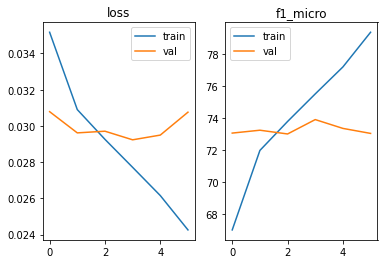

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=2)
ax[0].plot(list_train_loss, label='train')
ax[0].plot(list_val_loss, label='val')
ax[0].set_title('loss')
ax[0].legend()
ax[1].plot(list_train_f1_micro, label='train')
ax[1].plot(list_val_f1_micro, label='val')
ax[1].set_title('f1_micro')
ax[1].legend()
plt.show()
fig.savefig('performance.png')

In [ ]:
# Test

# Put model in evaluation mode to evaluate loss on the validation set
model.eval()

#track variables
logit_preds, true_labels, pred_labels, tokenized_texts = [],[],[],[]

# Predict
for i, batch in enumerate(test_dataloader):
  batch = tuple(t.to(device) for t in batch)
  # Unpack the inputs from our dataloader
  b_input_ids, b_input_mask, b_labels, b_token_types = batch
  with torch.no_grad():
    # Forward pass
    outs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)
    b_logit_pred = outs[0]
    pred_label = torch.sigmoid(b_logit_pred)

    b_logit_pred = b_logit_pred.detach().cpu().numpy()
    pred_label = pred_label.to('cpu').numpy()
    b_labels = b_labels.to('cpu').numpy()

  tokenized_texts.append(b_input_ids)
  logit_preds.append(b_logit_pred)
  true_labels.append(b_labels)
  pred_labels.append(pred_label)

# Flatten outputs
tokenized_texts = [item for sublist in tokenized_texts for item in sublist]
pred_labels = [item for sublist in pred_labels for item in sublist]
true_labels = [item for sublist in true_labels for item in sublist]

# Converting flattened binary values to boolean values
true_bools = [tl==1 for tl in true_labels]
pred_bools = [pl>threshold for pl in pred_labels] #boolean output after thresholding

# Print and save classification report
print('Test F1 Accuracy: ', f1_score(true_bools, pred_bools,average='micro'))
print('Test Flat Accuracy: ', accuracy_score(true_bools, pred_bools),'\n')
clf_report = classification_report(true_bools, pred_bools, target_names=list_classes)
pickle.dump(clf_report, open('classification_report.txt','wb')) #save report
print(clf_report)

Test F1 Accuracy:  0.7135678391959799
Test Flat Accuracy:  0.4685714285714286 

              precision    recall  f1-score   support

   empirical       0.60      0.69      0.64       214
 engineering       0.72      0.69      0.71       339
 theoretical       0.74      0.80      0.77       322

   micro avg       0.70      0.73      0.71       875
   macro avg       0.69      0.73      0.71       875
weighted avg       0.70      0.73      0.71       875
 samples avg       0.73      0.74      0.71       875



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
tokenizer = AutoTokenizer.from_pretrained('allenai/scibert_scivocab_uncased')

upl_encodings = tokenizer.batch_encode_plus(list(df_test.text.values), max_length=max_length, pad_to_max_length=True) # tokenizer's encoding method
upl_input_ids = upl_encodings['input_ids'] # tokenized and encoded sentences
upl_token_type_ids = upl_encodings['token_type_ids'] # token type ids
upl_attention_masks = upl_encodings['attention_mask'] # attention masks

upl_inputs = torch.tensor(upl_input_ids)
upl_masks = torch.tensor(upl_attention_masks)
upl_token_types = torch.tensor(upl_token_type_ids)

upl_data = TensorDataset(upl_inputs, upl_masks, upl_token_types)
upl_dataloader = DataLoader(upl_data, batch_size=batch_size)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.6/dist-packages/transformers/tokenization_utils_base.py:2179: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


In [ ]:
# model = AutoModelForSequenceClassification.from_pretrained('allenai/scibert_scivocab_uncased', num_labels=num_labels)
model = AutoModelForSequenceClassification.from_pretrained(path_model, num_labels=num_labels)
model.cuda()

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(31090, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

In [ ]:
model.eval()

#track variables
logit_preds, pred_labels, tokenized_texts = [],[],[]

# Predict
for i, batch in tqdm(enumerate(upl_dataloader), total=len(upl_dataloader)):
  batch = tuple(t.to(device) for t in batch)
  # Unpack the inputs from our dataloader
  b_input_ids, b_input_mask, b_token_types = batch
  with torch.no_grad():
    # Forward pass
    outs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)
    b_logit_pred = outs[0]
    pred_label = torch.sigmoid(b_logit_pred)

    b_logit_pred = b_logit_pred.detach().cpu().numpy()
    pred_label = pred_label.to('cpu').numpy()

  tokenized_texts.append(b_input_ids)
  logit_preds.append(b_logit_pred)
  pred_labels.append(pred_label)

# Flatten outputs
tokenized_texts = [item for sublist in tokenized_texts for item in sublist]
pred_labels = [item for sublist in pred_labels for item in sublist]

# Converting flattened binary values to boolean values
pred_bools = [pl>threshold for pl in pred_labels] #boolean output after thresholding

In [ ]:
df_upl = pd.DataFrame(pred_bools).astype(int)
df_upl.columns = [s.upper() for s in list_classes]

### 3 label
df_upl['OTHERS'] = (~df_upl.any(axis=1)).astype(int)

df_upl['Id'] = range(1, len(df_upl)+1)
df_upl = df_upl[['Id', 'THEORETICAL', 'ENGINEERING', 'EMPIRICAL', 'OTHERS']]
df_upl

,Id,THEORETICAL,ENGINEERING,EMPIRICAL,OTHERS
0,1,0,0,1,0
1,2,0,1,1,0
2,3,1,1,0,0
3,4,0,1,0,0
4,5,1,0,0,0
...,...,...,...,...,...
39995,39996,1,0,0,0
39996,39997,1,0,0,0
39997,39998,0,1,0,0
39998,39999,1,1,0,0


In [ ]:
df_upl[
    (df_upl.OTHERS == 1)
    & ((df_upl.THEORETICAL == 1) | (df_upl.ENGINEERING == 1) | (df_upl.EMPIRICAL == 1))
]

,Id,THEORETICAL,ENGINEERING,EMPIRICAL,OTHERS


In [ ]:
df_upl[
    (df_upl.OTHERS == 1)
]

In [ ]:
df_upl.to_csv('upload.csv', index=False)

# test for label description

In [ ]:
'''
Theoretical paper: A theoretical paper describes a theory or algorithm or provides a mathematical proof for some hypothesis.
Engineering paper: An engineering paper describes an implementation of an algorithm, 
or part or all of a computer system or application. Engineering papers are now frequently required to include descriptions of system evaluation.
Empirical paper: An empirical paper describes an experiment designed to test some hypothesis (more than one).
'''

'\nTheoretical paper: A theoretical paper describes a theory or algorithm or provides a mathematical proof for some hypothesis.\nEngineering paper: An engineering paper describes an implementation of an algorithm, \nor part or all of a computer system or application. Engineering papers are now frequently required to include descriptions of system evaluation.\nEmpirical paper: An empirical paper describes an experiment designed to test some hypothesis (more than one).\n'

In [ ]:
tokenizer = AutoTokenizer.from_pretrained('allenai/scibert_scivocab_uncased')

label_text = [
    'Theoretical paper: A theoretical paper describes a theory or algorithm or provides a mathematical proof for some hypothesis.',
    'Engineering paper: An engineering paper describes an implementation of an algorithm, or part or all of a computer system or application. Engineering papers are now frequently required to include descriptions of system evaluation.',
    'Empirical paper: An empirical paper describes an experiment designed to test some hypothesis (more than one).'
]

label_encodings = tokenizer.batch_encode_plus(label_text, max_length=max_length, pad_to_max_length=True) # tokenizer's encoding method
label_input_ids = label_encodings['input_ids'] # tokenized and encoded sentences
label_token_type_ids = label_encodings['token_type_ids'] # token type ids
label_attention_masks = label_encodings['attention_mask'] # attention masks

label_inputs = torch.tensor(label_input_ids)
label_masks = torch.tensor(label_attention_masks)
label_token_types = torch.tensor(label_token_type_ids)

label_data = TensorDataset(label_inputs, label_masks, label_token_types)
label_dataloader = DataLoader(label_data, batch_size=batch_size)

model = AutoModelForSequenceClassification.from_pretrained(path_model, num_labels=num_labels)
model.cuda()

In [ ]:
model.eval()

#track variables
logit_preds, pred_labels, tokenized_texts = [],[],[]

# Predict
for i, batch in tqdm(enumerate(label_dataloader), total=len(label_dataloader)):
  batch = tuple(t.to(device) for t in batch)
  # Unpack the inputs from our dataloader
  b_input_ids, b_input_mask, b_token_types = batch
  with torch.no_grad():
    # Forward pass
    outs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)
    b_logit_pred = outs[0]
    pred_label = torch.sigmoid(b_logit_pred)

    b_logit_pred = b_logit_pred.detach().cpu().numpy()
    pred_label = pred_label.to('cpu').numpy()

  tokenized_texts.append(b_input_ids)
  logit_preds.append(b_logit_pred)
  pred_labels.append(pred_label)

# Flatten outputs
tokenized_texts = [item for sublist in tokenized_texts for item in sublist]
pred_labels = [item for sublist in pred_labels for item in sublist]

# Converting flattened binary values to boolean values
pred_bools = [pl>0.50 for pl in pred_labels] #boolean output after thresholding

In [ ]:
df_lb = pd.DataFrame(pred_bools).astype(int)
df_lb.columns = [s.upper() for s in list_classes]
df_lb['Id'] = range(1, len(df_lb)+1)

df_lb = df_lb[['Id', 'THEORETICAL', 'ENGINEERING', 'EMPIRICAL', 'OTHERS']]
df_lb

In [ ]:
pred_labels

In [ ]:
list_classes

In [ ]:
for i in range(len(df_train)):
    if '(' not in df_train['Abstract'].loc[i]:
        continue

    print(i)
    print(df_train['Title'].iloc[i])

    for seg in df_train['Abstract'].loc[i].split('$$$'):
        print(seg)
    input('...')